# Setup

In [ ]:
from pathlib import Path

import _config as cfg
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl

results_dir = Path("Results")
results_dir.mkdir(parents=True, exist_ok=True)

perf_col = "f1"  # seems ok
# perf_col = "aroc"  # original
# perf_col = "balanced_accuracy"  # need to test

scaffold_old_col = "Id"
var_class_col = "Variant_Classification"
prot_change_col = "Protein_Change"
gene_name_col = "gene_name"
contig_col = "contig"

perf_delta_col = "Performance_delta"
scaffold_col = "scaffold"

promisc_new_col = "Promiscuity"
bin_id_col = "Bin_idx"

list_separator = ";"

# Unique colors for variants
variants = [
    "Missense_Mutation",
    "Intron",
    "Silent",
    "Splice_Site",
    "Nonsense_Mutation",
    "Frame_Shift_Del",
    "IGR",
    "3'UTR",
    "5'Flank",
    "5'UTR",
    "RNA",
    "Frame_Shift_Ins",
    "In_Frame_Del",
    "lincRNA",
    "In_Frame_Ins",
    "Start_Codon_SNP",
    "Nonstop_Mutation",
    "De_novo_Start_OutOfFrame",
    "De_novo_Start_InFrame",
    "Stop_Codon_Del",
    "Start_Codon_Del",
    "Start_Codon_Ins",
]
variants_n = len(variants)
variants_colors = {}
if variants_n <= 10:
    c = {variants[i]: plt.color_sequences["tab10"][i] for i in range(variants_n)}
    variants_colors.update(c)
else:
    c = {variants[i]: plt.color_sequences["tab10"][i] for i in range(10)}
    variants_colors.update(c)
    vn_rest = variants_n - 10
    if vn_rest <= 10:
        c = {
            variants[i]: plt.color_sequences["tab20"][j]
            for i, j in zip(range(10, 10 + vn_rest), range(1, 2 * vn_rest, 2))
        }
        variants_colors.update(c)
    else:
        c = {
            variants[i]: plt.color_sequences["tab20"][j]
            for i, j in zip(range(10, 20), range(1, 20, 2))
        }
        variants_colors.update(c)
        vn_rest -= 10
        if vn_rest <= 9:
            c = {
                variants[i]: plt.color_sequences["Pastel1"][j]
                for i, j in zip(range(20, 20 + vn_rest), range(vn_rest))
            }
            variants_colors.update(c)
        else:
            raise ValueError("No colors left, yet")
# Color for `Other`
variants_colors_other = "0.55"

# Matplotlib config

plt.rcdefaults()

main_font_size = 6
label_font_size = 10

axis_color = "0.15"

plt.rcParams["text.color"] = axis_color
plt.rcParams["axes.labelcolor"] = axis_color
plt.rcParams["xtick.color"] = axis_color
plt.rcParams["ytick.color"] = axis_color
plt.rcParams["axes.edgecolor"] = axis_color

plt.rcParams["font.size"] = main_font_size
plt.rcParams["axes.labelsize"] = main_font_size
plt.rcParams["axes.titlesize"] = main_font_size
plt.rcParams["xtick.labelsize"] = main_font_size
plt.rcParams["ytick.labelsize"] = main_font_size
plt.rcParams["legend.fontsize"] = main_font_size
plt.rcParams["figure.labelsize"] = main_font_size
plt.rcParams["figure.titlesize"] = main_font_size

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

plt.rcParams["savefig.transparent"] = True

plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"

#


def figsize_in_mm(width, height):
    mm = 1 / 25.4  # millimeters in inches
    return (width * mm, height * mm)

# Data Preparation

In [60]:
# Scaffold level

# Config
config = cfg.configurations[3]
mut_remove_results_file = results_dir / "mutation-remove-experiments-Scaffold_level.csv"
mut_join_col = scaffold_col
promisc_col = "popcov_but_sqrt"
pd_int_cols = {"unique_peptides": "Int64"}
unique_cols = [
    "Chromosome",
    "Start_position",
    "End_position",
    "unique_peptides",
    "popcov_but_sqrt",
]
best_genes_cols = [
    gene_name_col,
    prot_change_col,
    scaffold_col,
    promisc_col,
    perf_delta_col,
]
prot_change_extra_col = prot_change_col + "_extra"
#

model_name = config["plot_label"]

mutset = pd.read_csv(
    config["contig_file"], sep="\t", low_memory=False, dtype=pd_int_cols
)
# Filter the file like in 'DataSets_validation.py' first:
if config["hotspots"]:
    mutset = mutset.loc[mutset["contig"].notna()]
mutset = mutset.dropna(
    axis="index", how="any", subset=unique_cols, ignore_index=True
).drop_duplicates(unique_cols, ignore_index=True)
mutset = pl.DataFrame(mutset)

# Renaming for scaffolds only:
mutset = mutset.rename({scaffold_old_col: scaffold_col})

contigmut = pl.read_csv(mut_remove_results_file)

aroccontigmut = contigmut[perf_col][0]

contig_mutations_with_delta = (
    contigmut.slice(1)
    .with_columns((aroccontigmut - pl.col(perf_col)).alias(perf_delta_col))
    .sort(perf_delta_col, descending=True)
)

# Add model performance info to mutations
#  The `filter` construction might be scaffold/contig-only
mutset = (
    mutset.join(
        contig_mutations_with_delta,
        on=mut_join_col,
        suffix="_dup",
        how="left",
        coalesce=False,
    )
    .filter(pl.col(mut_join_col).is_not_null())
    .sort(perf_delta_col, descending=True)
)

# Deal with some list columns (scaffold/contig-only)
contig_mutations_with_delta = contig_mutations_with_delta.with_columns(
    pl.col(prot_change_col).fill_null("").str.split(list_separator),
    pl.col(gene_name_col).fill_null("").str.split(list_separator),
)
contig_mutations_with_delta = contig_mutations_with_delta.with_columns(
    pl.col(prot_change_col)
    .list.unique()
    .list.set_difference([""])
    .alias(prot_change_extra_col)
).with_columns(
    pl.when(pl.col(prot_change_extra_col).list.len() > 0).then(
        pl.col(prot_change_extra_col)
    )
)

print(
    "Performance delta range: ("
    f"{contig_mutations_with_delta[perf_delta_col].min()}"
    ", "
    f"{contig_mutations_with_delta[perf_delta_col].max()}"
    ")"
)

Performance delta range: (0.08907742584213174, 0.45051006341328925)


In [64]:
mutset

mutid,Sample_ID,Chromosome,Start_position,End_position,Variant_Classification,Variant_Type,cDNA_Change,Codon_Change,Protein_Change,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_ref_count,Tumor_alt_count,gene_name,SUBJID,contig,Sample_ID_right,Chromosome_right,Start_position_right,End_position_right,Variant_Classification_right,Variant_Type_right,cDNA_Change_right,Codon_Change_right,Protein_Change_right,Reference_Allele_right,Tumor_Seq_Allele1_right,Tumor_Seq_Allele2_right,Tumor_ref_count_right,Tumor_alt_count_right,gene_name_right,SUBJID_right,contig_right,scaffold,Chromosome_1,Gene_start,Gene_end,Multi_contig,gap_width,unique_peptides,n_unique_HLA,popcov_but_sqrt,popcov_but_sqrt2,popcov_but_sqrt3,popcov_but_sqrt4,exclude_mutation,aroc,precision,recall,f1,precision_true,recall_true,f1_true,precision_false,recall_false,f1_false,accuracy,scaffold_dup,unique_peptides_dup,popcov_but_sqrt_dup,Chromosome_dup,Start_position_dup,End_position_dup,Variant_Classification_dup,Protein_Change_dup,gene_name_dup,Gene_count,Performance_delta
i64,str,str,i64,i64,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,str,f64,f64,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,str,f64,f64,str,f64,i64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,f64,str,str,str,str,str,str,i64,f64
9759,"""EA699728""","""14""",60149247,60149247,"""Intron""","""SNP""",null,null,null,"""A""","""A""","""G""",13.0,3.0,"""DHRS7""","""RCC25-122""","""C166587""","""EA699728""","""14""",6.0149247e7,6.0149247e7,"""Intron""","""SNP""",null,null,null,"""A""","""A""","""G""",13.0,3.0,"""DHRS7""","""RCC25-122""","""C166587""","""S_10_138835""","""14""",6.0144975e7,6.0149514e7,"""N""",10.0,231,231.0,17.70797,0.0,0.0,0.0,"""S_10_138835""",0.635734,0.327273,0.473684,0.387097,0.0,0.0,0.0,0.654545,0.947368,0.774194,0.631579,"""S_10_138835""",231,17.70797,"""14;14;14""","""60149247;60149249;60149465""","""60149247;60149249;60149465""","""Intron;Intron;Missense_Mutatio…",""";;p.S287L""","""DHRS7;DHRS7;DHRS7""",3,0.45051
24042,"""RCC_52-Tumor-SM-A46EU""","""17""",67145781,67145781,"""Missense_Mutation""","""SNP""","""c.2731C>A""","""c.(2731-2733)Caa>Aaa""","""p.Q911K""","""G""","""G""","""T""",120.0,10.0,"""HELZ""","""RCC_52""","""C201986""","""RCC_52-Tumor-SM-A46EU""","""17""",6.7145781e7,6.7145781e7,"""Missense_Mutation""","""SNP""","""c.2731C>A""","""c.(2731-2733)Caa>Aaa""","""p.Q911K""","""G""","""G""","""T""",120.0,10.0,"""HELZ""","""RCC_52""","""C201986""","""S_10_168135""","""17""",6.7136155e7,6.7145784e7,"""Y""",10.0,275,275.0,116.726529,1.286881,0.0,0.0,"""S_10_168135""",0.645429,0.327273,0.473684,0.387097,0.0,0.0,0.0,0.654545,0.947368,0.774194,0.631579,"""S_10_168135""",275,116.726529,"""17;17;17;17""","""67145781;67138045;67137999;671…","""67145781;67138045;67137999;671…","""Missense_Mutation;Missense_Mut…","""p.Q911K;p.D947N;p.R962K;p.E912…","""HELZ;HELZ;HELZ;HELZ""",4,0.45051
26828,"""EA698911""","""17""",67138045,67138045,"""Missense_Mutation""","""SNP""","""c.2839G>A""","""c.(2839-2841)Gat>Aat""","""p.D947N""","""C""","""C""","""T""",118.0,5.0,"""HELZ""","""RCC25-861""","""C201984""","""EA698911""","""17""",6.7138045e7,6.7138045e7,"""Missense_Mutation""","""SNP""","""c.2839G>A""","""c.(2839-2841)Gat>Aat""","""p.D947N""","""C""","""C""","""T""",118.0,5.0,"""HELZ""","""RCC25-861""","""C201984""","""S_10_168135""","""17""",6.7136155e7,6.7145784e7,"""Y""",10.0,275,275.0,116.726529,1.286881,0.0,0.0,"""S_10_168135""",0.645429,0.327273,0.473684,0.387097,0.0,0.0,0.0,0.654545,0.947368,0.774194,0.631579,"""S_10_168135""",275,116.726529,"""17;17;17;17""","""67145781;67138045;67137999;671…","""67145781;67138045;67137999;671…","""Missense_Mutation;Missense_Mut…","""p.Q911K;p.D947N;p.R962K;p.E912…","""HELZ;HELZ;HELZ;HELZ""",4,0.45051
47890,"""EA699631""","""14""",60149249,60149249,"""Intron""","""SNP""",null,null,null,"""A""","""A""","""G""",5.0,3.0,"""DHRS7""","""RCC25-788""","""C166587""","""EA699631""","""14""",6.0149249e7,6.0149

# Results

## Performance Delta Distribution

shape: (1_367, 6)
┌───────────┬────────────────┬─────────────┬─────────────┬───────────────────┬─────────┐
│ gene_name ┆ Protein_Change ┆ scaffold    ┆ Promiscuity ┆ Performance_delta ┆ Bin_idx │
│ ---       ┆ ---            ┆ ---         ┆ ---         ┆ ---               ┆ ---     │
│ str       ┆ str            ┆ str         ┆ f64         ┆ f64               ┆ i32     │
╞═══════════╪════════════════╪═════════════╪═════════════╪═══════════════════╪═════════╡
│ ACTG1     ┆ p.E2K          ┆ S_10_170159 ┆ 1904.709638 ┆ 0.298654          ┆ 18      │
│ ACTG1     ┆ p.G42D         ┆ S_10_170159 ┆ 1904.709638 ┆ 0.298654          ┆ 18      │
│ ACTG1     ┆ p.L140L        ┆ S_10_170159 ┆ 1904.709638 ┆ 0.298654          ┆ 18      │
│ ACTG1     ┆ p.N296K        ┆ S_10_170159 ┆ 1904.709638 ┆ 0.298654          ┆ 18      │
│ ACTG1     ┆ p.R95H         ┆ S_10_170159 ┆ 1904.709638 ┆ 0.298654          ┆ 18      │
│ …         ┆ …              ┆ …           ┆ …           ┆ …                 ┆ …       │
│ P

shape: (1_206, 6)
┌───────────┬────────────────┬─────────────┬─────────────┬───────────────────┬─────────┐
│ gene_name ┆ Protein_Change ┆ scaffold    ┆ Promiscuity ┆ Performance_delta ┆ Bin_idx │
│ ---       ┆ ---            ┆ ---         ┆ ---         ┆ ---               ┆ ---     │
│ str       ┆ str            ┆ str         ┆ f64         ┆ f64               ┆ i32     │
╞═══════════╪════════════════╪═════════════╪═════════════╪═══════════════════╪═════════╡
│ KLF16     ┆ p.Y139*        ┆ S_10_174521 ┆ 12.989626   ┆ 0.216344          ┆ 13      │
│ RBCK1     ┆ p.E433D        ┆ S_10_187759 ┆ 12.987135   ┆ 0.311291          ┆ 19      │
│ SLCO3A1   ┆ p.E127K        ┆ S_10_149498 ┆ 12.951693   ┆ 0.24277           ┆ 15      │
│ WDR35     ┆ p.F173F        ┆ S_10_21724  ┆ 12.944362   ┆ 0.284188          ┆ 17      │
│ TUBGCP6   ┆ p.R1797H       ┆ S_10_198941 ┆ 12.942886   ┆ 0.21774           ┆ 13      │
│ …         ┆ …              ┆ …           ┆ …           ┆ …                 ┆ …       │
│ C

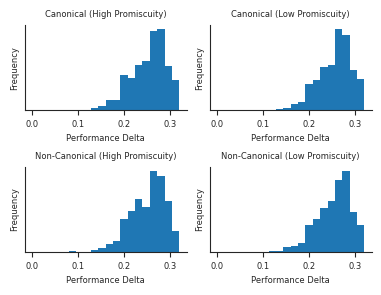

In [62]:
# Config
promisc_boundary = 13
perf_delta_x_range = (0.0, 0.32)

fig_size = figsize_in_mm(94, 72)

top_genes_n = 100
#

base_df = contig_mutations_with_delta
prot_change_test_col = prot_change_extra_col

canonical = base_df.filter(pl.col(prot_change_test_col).is_not_null())
non_canonical = base_df.filter(pl.col(prot_change_test_col).is_null())

canonical_high = canonical.filter(pl.col(promisc_col) > promisc_boundary)
canonical_low = canonical.filter(pl.col(promisc_col) <= promisc_boundary)
non_canonical_high = non_canonical.filter(pl.col(promisc_col) > promisc_boundary)
non_canonical_low = non_canonical.filter(pl.col(promisc_col) <= promisc_boundary)

data_subgroups = {
    "Canonical (High Promiscuity)": canonical_high,
    "Canonical (Low Promiscuity)": canonical_low,
    "Non-Canonical (High Promiscuity)": non_canonical_high,
    "Non-Canonical (Low Promiscuity)": non_canonical_low,
}

# Fig

fig, axes = plt.subplots(2, 2, figsize=fig_size, layout="constrained")
for ax, (title, series) in zip(axes.flatten(), data_subgroups.items()):
    h_out = ax.hist(
        series[perf_delta_col], bins=20, density=False, range=perf_delta_x_range
    )
    ax.set_title(title)
    ax.set_xlabel("Performance Delta")
    ax.set_ylabel("Frequency")
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Save top N genes from each bin:

    bin_n = h_out[0][::-1]
    bin_starts = h_out[1]
    bin_ranges = [
        (bin_starts[i], bin_starts[i + 1]) for i in range(len(bin_starts) - 1)
    ][::-1]
    bin_ids = [i for i in range(len(bin_n))][::-1]

    top_genes = []

    for b_n, (b_s, b_e), b_id in zip(bin_n, bin_ranges, bin_ids):
        if b_n == 0:
            continue
        b_series = series.filter(
            (pl.col(perf_delta_col) >= b_s) & (pl.col(perf_delta_col) < b_e)
        ).select(pl.col(best_genes_cols))
        # Explode to singular genes
        #   Might work only with scaffolds/contigs
        b_series = (
            b_series.explode([gene_name_col, prot_change_col])
            .unique()
            .sort(
                [promisc_col, gene_name_col, prot_change_col, mut_join_col],
                descending=[True, False, False, False],
            )
            .with_columns(pl.lit(b_id).alias(bin_id_col))
        )
        #
        # Remove non-canonical genes from the canonical group
        if title.startswith("Canonical "):
            b_series = b_series.filter(pl.col(prot_change_col) != "")
        elif not title.startswith("Non-Canonical "):
            raise ValueError(
                "String check not compatible with keys in `data_subgroups`"
            )
        #
        # Take first top N promiscuity values (dense row selection)
        b_series = b_series.filter(
            pl.col(promisc_col).rank(method="dense", descending=True) <= top_genes_n
        )
        #
        top_genes.append(b_series)

    top_genes = pl.concat(top_genes).sort(
        [promisc_col, perf_delta_col, gene_name_col, prot_change_col, mut_join_col],
        descending=[True, True, False, False, False],
    )
    top_genes = top_genes.rename({promisc_col: promisc_new_col})
    print(top_genes)

    title_mod = title.lower().replace("(", "").replace(")", "").replace(" ", "_")
    f_name = f"top-bin-genes-{title_mod}-{model_name.replace(' ', '_')}.csv"
    top_genes.write_csv(results_dir / f_name)
for fmt in ("pdf", "png"):
    fig.savefig(
        results_dir
        / f"performance-delta-histograms-{model_name.replace(' ', '_')}.{fmt}",
        dpi=600,
    )

## Variant Classifications Distribution

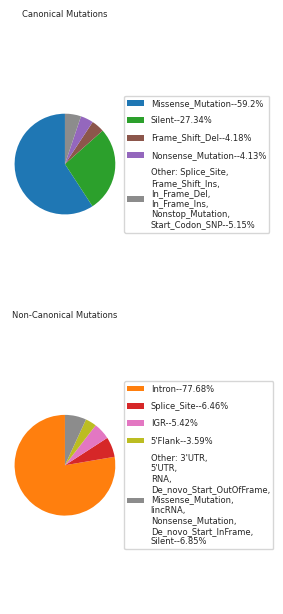

In [63]:
# Config
base_df = mutset
prot_change_test_col = prot_change_col

fig_size = figsize_in_mm(69.0, 153.0)
n_other_groups = [6, 9]
#

canonical = base_df.filter(pl.col(prot_change_test_col).is_not_null())
non_canonical = base_df.filter(pl.col(prot_change_test_col).is_null())

groups = [
    ("Canonical Mutations", canonical),
    ("Non-Canonical Mutations", non_canonical),
]

# Fig

fig, axes_pie = plt.subplots(2, 1, figsize=fig_size, layout="constrained")
for ax, (title, group_df), n_other in zip(axes_pie.flatten(), groups, n_other_groups):
    counts = group_df.group_by(var_class_col).len().sort("len", descending=True)
    labels = counts[var_class_col]
    sizes = counts["len"]
    n_labels = len(labels)
    if 0 < n_other < n_labels:
        other_sum = sizes.slice(-n_other).sum()
        sizes = sizes.slice(0, n_labels - n_other).append(
            pl.Series("a", [other_sum], dtype=pl.UInt32)
        )
        other_label = "Other: " + ",\n".join(labels.slice(-n_other).to_list())
        labels = labels.slice(0, n_labels - n_other).append(
            pl.Series("a", [other_label])
        )
        n_labels = len(labels)
    elif n_other >= n_labels:
        raise ValueError("Too much labels compressed into `n_other_groups`")
    colors = [
        variants_colors_other if lab.startswith("Other: ") else variants_colors[lab]
        for lab in labels
    ]
    wedges, _ = ax.pie(
        sizes,
        labels=labels,
        colors=colors,
        autopct=None,
        startangle=90,
        labeldistance=None,
    )
    ax.set_title(title)
    percents = (sizes / sizes.sum() * 100).round(2)
    legend_labels = [f"{lab}--{p}%" for lab, p in zip(labels, percents)]
    ax.legend(
        wedges,
        legend_labels,
        loc="center left",
        bbox_to_anchor=(1, 0, 0.5, 1),
        labelspacing=1,
    )
    ax.axis("equal")
for fmt in ("pdf", "png"):
    fig.savefig(
        results_dir
        / f"variant-classifications-pie-charts-{model_name.replace(' ', '_')}.{fmt}",
        dpi=600,
    )